In [9]:
from __future__ import annotations

from pathlib import Path

import geopandas as gpd

from slope_area._internal.dem import (
    VRT,
    DEMSource,
    DEMTiles,
    DEMTilesBuilder,
    DynamicVRT,
    GeneralizedDEM,
)
from slope_area.builder import (
    BuilderConfig,
    OutletPlotBuilder,
    ResolutionPlotBuilder,
)
from slope_area.features import Outlets
from slope_area.geomorphometry import HydrologicAnalysisConfig
from slope_area.logger import create_logger
from slope_area.paths import PROJ_ROOT
from slope_area.plot import SlopeAreaPlotConfig

logger = create_logger(__name__)

# Paths

In [10]:
outlets = PROJ_ROOT / 'data' / 'raw' / 'outlets.shp'

out_dir = PROJ_ROOT / 'data' / 'processed' / '02_internal_example'
out_dir_outlet_builder = out_dir / 'outlet_builder'
out_dir_resolution_builder = out_dir / 'resolution_builder'

out_fig_outlet_builder = out_dir_outlet_builder / 'slope_area.png'
out_fig_resolution_builder = out_dir_resolution_builder / 'slope_area.png'

# Internal data
dem_dir = PROJ_ROOT / 'data' / 'raw' / 'DEM'
dem_tiles = PROJ_ROOT / 'data' / 'raw' / 'dem_tiles.fgb'
generalized_dem_path = PROJ_ROOT / 'data' / 'raw' / 'dem_30m.tif'
generalized_dem_out = out_dir / generalized_dem_path.stem

# Run configs

In [11]:
dem_dir_epsg = 3844
max_workers = 3
hydrologic_analysis_config = HydrologicAnalysisConfig(
    streams_flow_accumulation_threshold=1000, outlet_snap_distance=100
)
plot_config = SlopeAreaPlotConfig(
    hue='slope_type',
    col='trial',
    log_interval=0.25,
    min_gradient=0.01,
    col_wrap=-1,
    height=5,
    aspect=1,
    title=None,
    xlabel='Drainage area (m$^2$)',
    ylabel='Slope (m/m)',
    label_font_size=16,
    title_font_size=10,
    legend_font_size=10,
    tick_font_size=14,
    add_vlines=False,
    kind='line',
    show=True,
)

# Internal objects for the Prut-Bârlad Water Administration LiDAR dataset
tiles = DEMTilesBuilder(
    dem_dir, dem_dir_epsg=dem_dir_epsg, tiles=dem_tiles
).build()
generalized_dem = GeneralizedDEM(
    path=generalized_dem_path, out_dir=generalized_dem_out
)
dem_source = DEMSource(dem_dir, tiles, generalized_dem, crs=3844)

10:38:17 INFO slopeArea.slope_area._internal.dem.DEMTilesBuilder                build(): Found DEM tiles at /media/alex/alex/python-modules-packages-utils/slope-area/data/raw/dem_tiles.fgb


# Read outlets

In [12]:
logger.info('Reading outlets at %s' % outlets)
gdf = gpd.read_file(outlets).sort_values(by='name')
gdf = gdf[gdf['is_gully'] == 1]
outlets = Outlets.from_gdf(gdf, name_field='name')

10:38:17 INFO slopeArea.__main__             <module>(): Reading outlets at /media/alex/alex/python-modules-packages-utils/slope-area/data/raw/outlets.shp


# Plot comparing different DEM resolutions

10:38:17 INFO slopeArea.slope_area._internal.dem.DEMTiles          from_outlet(): Infering DEM tiles based on the outlet
10:38:19 INFO slopeArea.slope_area._internal.dem.DEMTiles       write_whitebox(): Saving Vector object to /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/02_internal_example/resolution_builder/watershed.shp
10:38:20 INFO slopeArea.slope_area._internal.dem.DEMTiles         from_polygon(): Extracted 6 tiles based on the polygon <POLYGON ((650962 642080, 651052 642080, 651052 642050, 651172 642050, 65117...>
10:38:20 INFO slopeArea.slope_area._internal.dem              wrapper(): DEMTiles.from_outlet executed in 3.157164 seconds
10:38:20 INFO slopeArea.slope_area._internal.dem       from_dem_tiles(): Building VRT from 6 rasters


Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************
**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


10:38:47 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor
10:38:47 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, legend_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend=True, show=True)
10:38:47 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 5 cols for the plot
10:38:55 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/02_internal_example/resolution_builder/slope_area.png


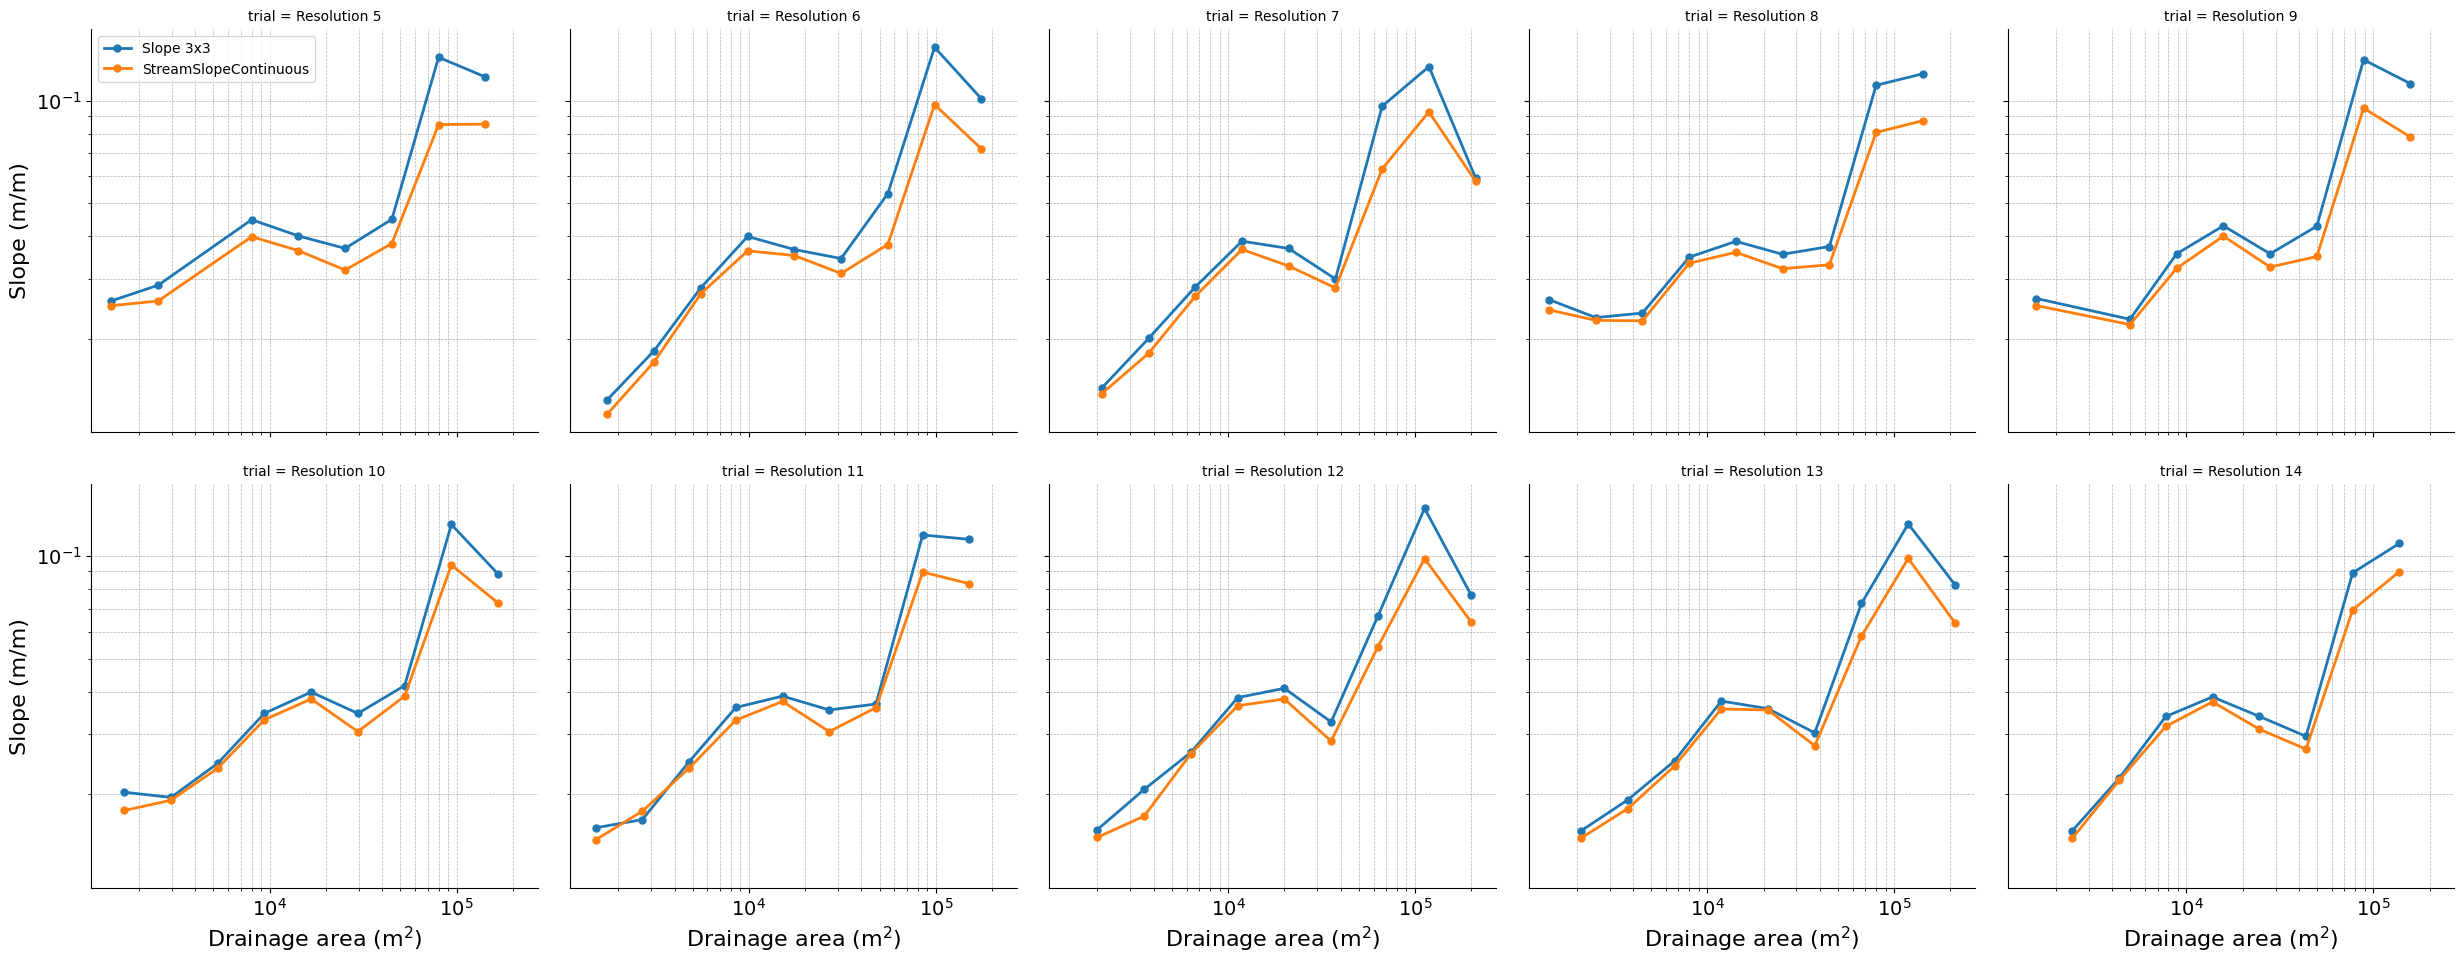

In [13]:
resolutions = [(res, res) for res in range(5, 15)]
outlet_name = 'gully 2'

builder_config = BuilderConfig(
    hydrologic_analysis_config=hydrologic_analysis_config,
    out_dir=out_dir_resolution_builder,
    out_fig=out_fig_resolution_builder,
    plot_config=plot_config,
    max_workers=max_workers,
)

outlet = [outlet for outlet in outlets if outlet.name == outlet_name][0]

dem = Path(builder_config.out_dir) / 'dem.vrt'
dem_tiles = DEMTiles.from_outlet(
    dem_source=dem_source,
    outlet=outlet,
    out_dir=builder_config.out_dir,
    outlet_snap_dist=builder_config.hydrologic_analysis_config.outlet_snap_distance,
)
vrt = VRT.from_dem_tiles(dem_tiles, dem).define_projection(dem_source.crs)

results = ResolutionPlotBuilder(
    builder_config, vrt, outlet, resolutions
).build()

Output()

**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


**********************************************************************************
            DEM needs to be processed to remove topographic depressions and flats prior to
            running this tool.
**********************************************************************************


10:41:32 INFO slopeArea.slope_area.builder.TrialsExecutor               gather(): Gathering results of TrialsExecutor
10:41:33 INFO slopeArea.slope_area.plot      slope_area_grid(): Creating slope area plot with config SlopeAreaPlotConfig(hue='slope_type', col='trial', log_interval=0.25, min_gradient=0.01, col_wrap=-1, height=5, aspect=1, title=None, xlabel='Drainage area (m$^2$)', ylabel='Slope (m/m)', label_font_size=16, title_font_size=10, legend_font_size=10, tick_font_size=14, add_vlines=False, kind='line', grid=True, legend=True, show=True)
10:41:33 INFO slopeArea.slope_area.plot         get_col_wrap(): Infered 4 cols for the plot
10:41:51 INFO slopeArea.slope_area.plot      slope_area_grid(): Saved slope area plot at /media/alex/alex/python-modules-packages-utils/slope-area/data/processed/02_internal_example/outlet_builder/slope_area.png


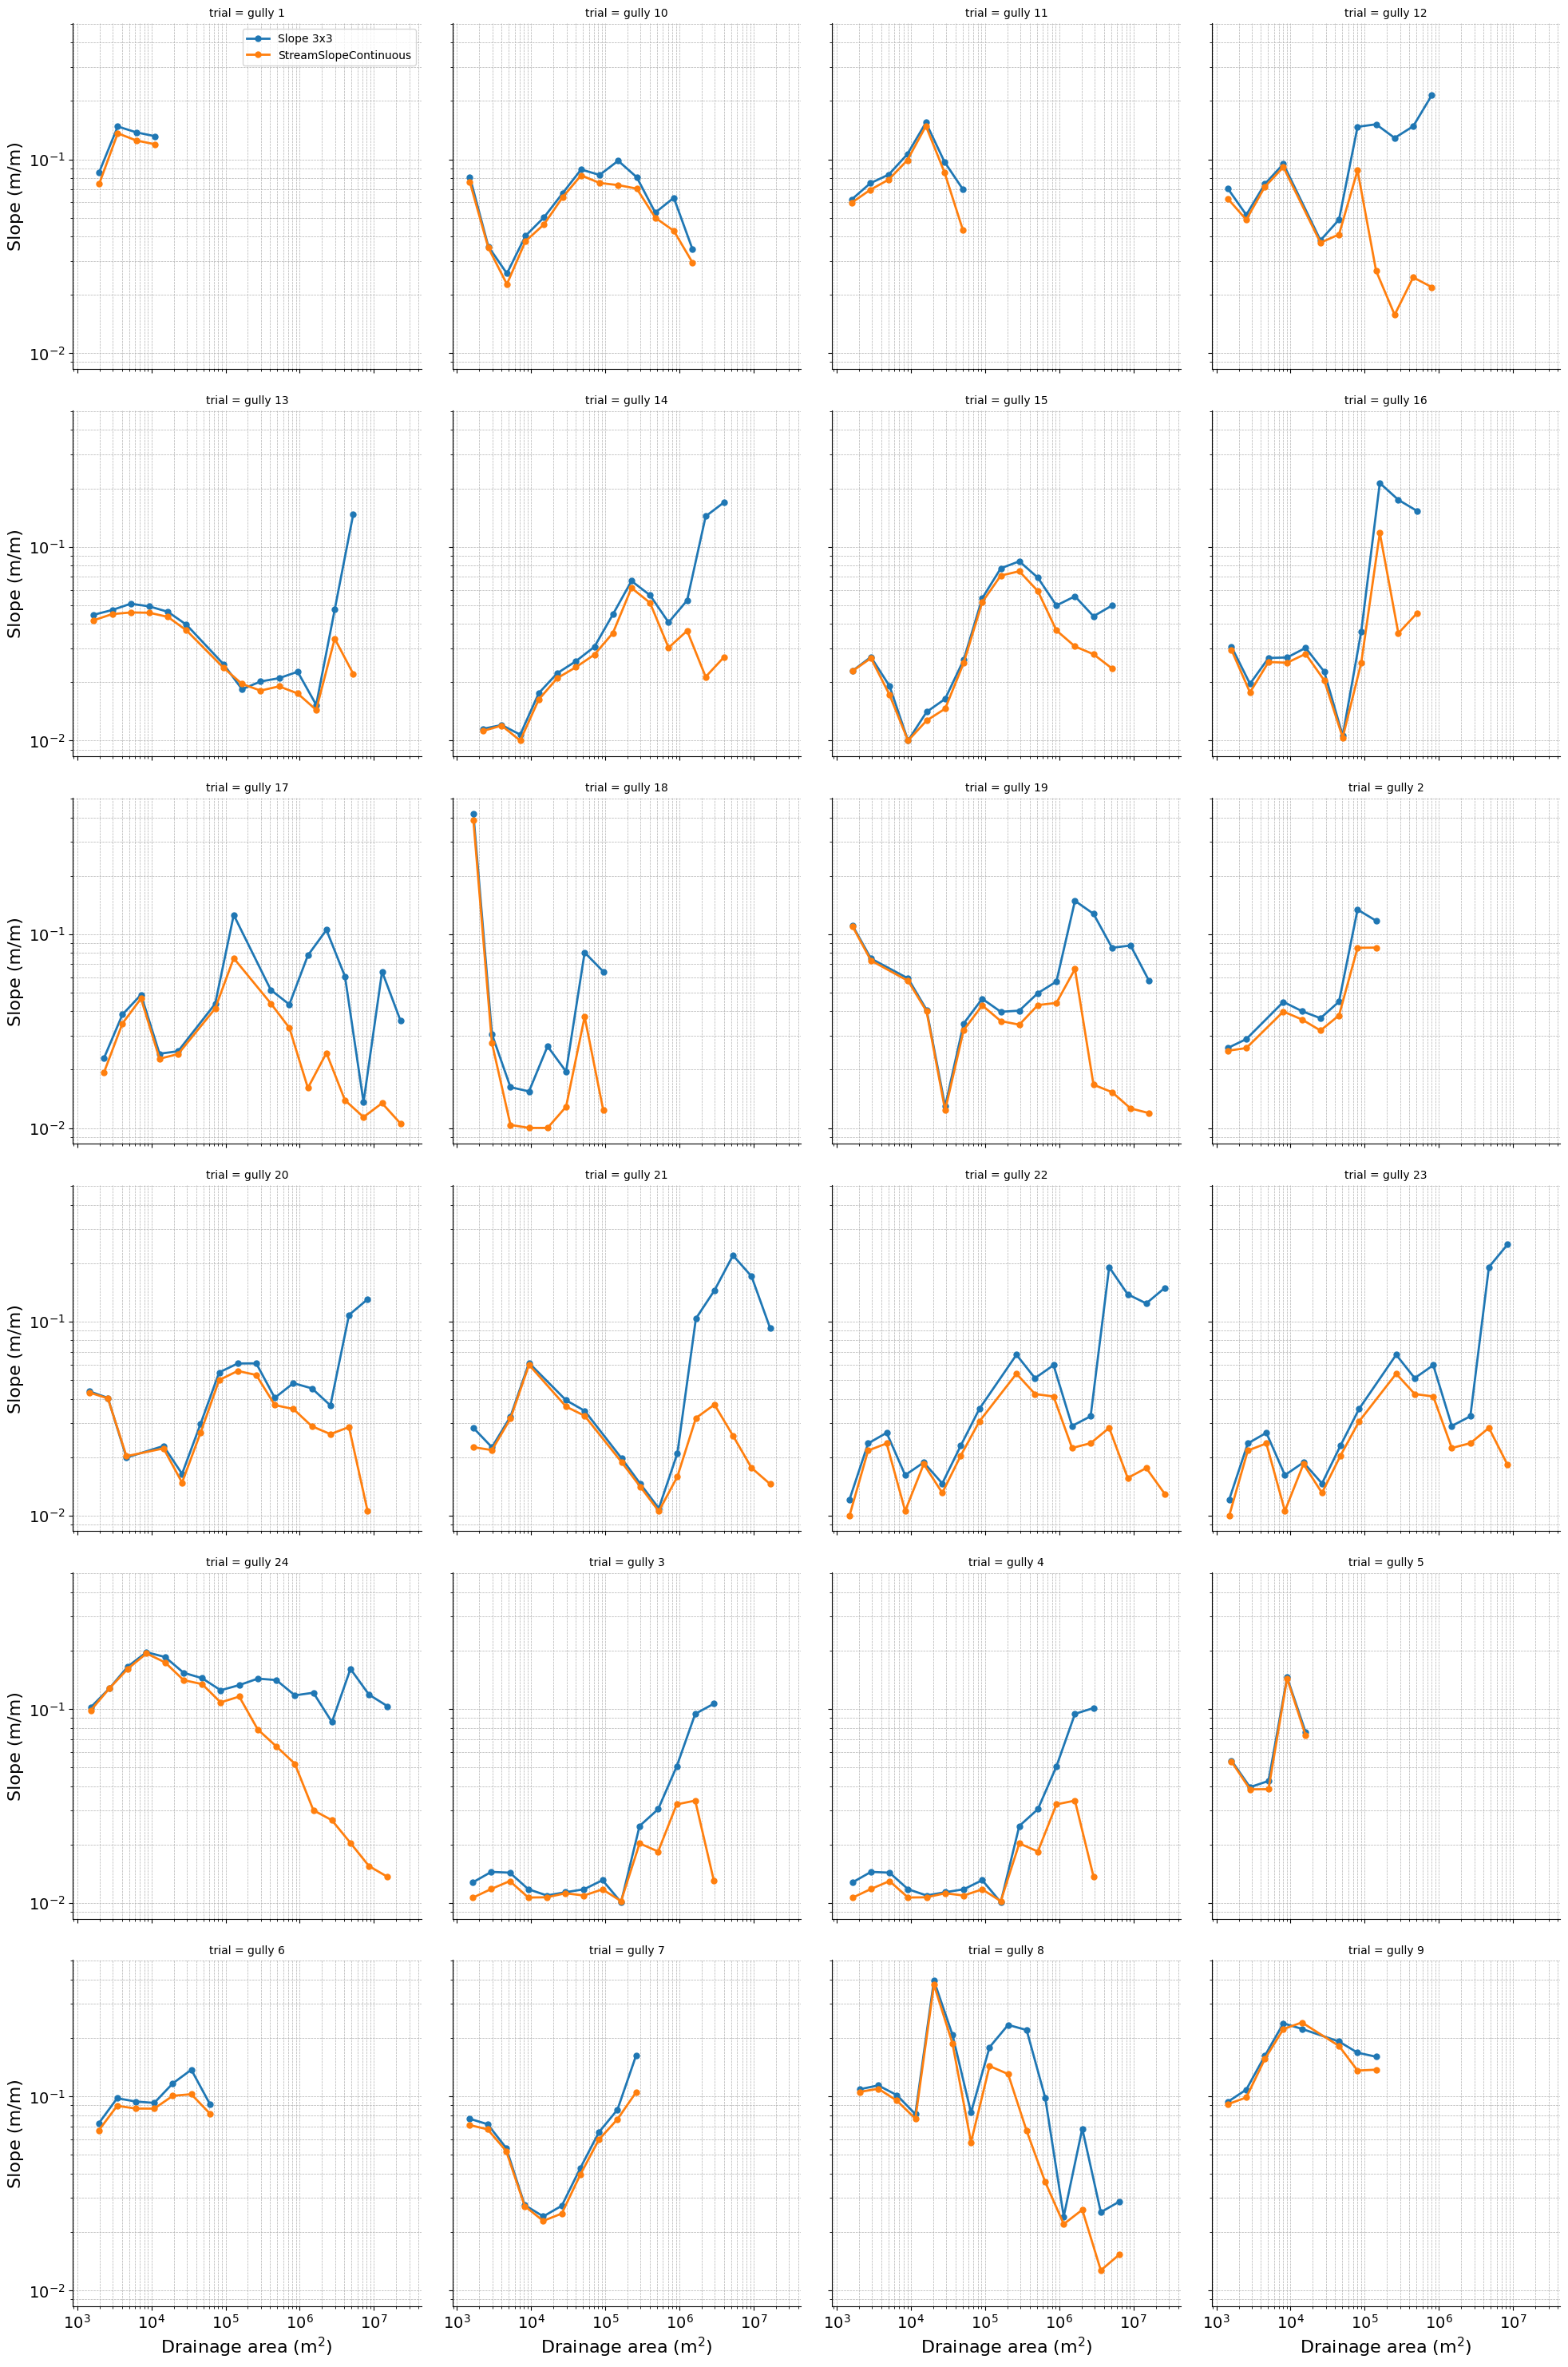

In [14]:
resolution = (5, 5)

builder_config = BuilderConfig(
    hydrologic_analysis_config=hydrologic_analysis_config,
    out_dir=out_dir_outlet_builder,
    out_fig=out_fig_outlet_builder,
    plot_config=plot_config,
    max_workers=max_workers,
)

# Computing the DEM for each outlet is a heavy process with the internal dataset.
# The DynamicVRT allows to compute the VRT from DEMTiles in the process of each Trial
# DynamicVRT follows the DEMProvider interface
dem_provider = DynamicVRT(
    dem_source, out_dir_outlet_builder, outlet_snap_distance=100
)

results = OutletPlotBuilder(
    builder_config, dem=dem_provider, outlets=outlets, resolution=resolution
).build()